In [2]:
import numpy as np
import pandas as pd
from math import sqrt

In [21]:
week1=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_1.csv")
week2=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_2.csv")
week3=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_3.csv")
week4=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_4.csv")
week5=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_5.csv")
week6=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_6.csv")
week7=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_7.csv")
week8=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_8.csv")
week9=pd.read_csv("nfl-big-data-bowl-2024/tracking_week_9.csv")
plays=pd.read_csv("nfl-big-data-bowl-2024/plays.csv")
games=pd.read_csv("nfl-big-data-bowl-2024/games.csv")
players=pd.read_csv("nfl-big-data-bowl-2024/players.csv")
tackles=pd.read_csv("nfl-big-data-bowl-2024/tackles.csv")

In [4]:
all_plays=pd.concat([week1, week2, week3, week4, week5, week6, week7, week8, week9],axis=0)
plays["uniqueid"]=plays["gameId"]*plays["playId"]
all_plays["uniqueid"]=all_plays["gameId"]*all_plays["playId"]
plays_final=pd.merge(plays,games, on="gameId",how="right")
plays_final=plays_final[plays_final["playNullifiedByPenalty"]=="N"]
plays_final.drop(["gameId","playId","ballCarrierDisplayName","playDescription","prePenaltyPlayResult","playNullifiedByPenalty",
                 "foulName1","foulName2","penaltyYards","foulNFLId1","foulNFLId2","season","gameDate","gameTimeEastern"],axis=1,inplace=True)
def assign_offense_defense(row):
    if row['possessionTeam'] == row['homeTeamAbbr']:
        row['offenseScore'] = row['preSnapHomeScore']
        row['defenseScore'] = row['preSnapVisitorScore']
        row['offenseWinProbability'] = row['preSnapHomeTeamWinProbability']
        row['offenseWPAdded']=row["homeTeamWinProbabilityAdded"]
        row['defenseWinProbability'] = row['preSnapVisitorTeamWinProbability']
        row['defenseWPAdded']=row["visitorTeamWinProbilityAdded"]
    else:
        row['offenseScore'] = row['preSnapVisitorScore']
        row['defenseScore'] = row['preSnapHomeScore']
        row['offenseWinProbability'] = row['preSnapVisitorTeamWinProbability']
        row['offenseWPAdded']=row["visitorTeamWinProbilityAdded"]
        row['defenseWinProbability'] = row['preSnapHomeTeamWinProbability']
        row['defenseWPAdded']=row["homeTeamWinProbabilityAdded"]
    return row

plays_final = plays_final.apply(assign_offense_defense, axis=1)
plays_final=plays_final.drop(["preSnapHomeScore","preSnapVisitorScore","preSnapHomeTeamWinProbability","preSnapVisitorTeamWinProbability",
                             "homeFinalScore","visitorFinalScore","homeTeamWinProbabilityAdded","visitorTeamWinProbilityAdded"], axis=1)
all_plays=pd.merge(all_plays, games, on="gameId",how="right")
all_plays.drop(["gameDate","gameTimeEastern","homeTeamAbbr","visitorTeamAbbr","homeFinalScore","visitorFinalScore"],axis=1, inplace=True)
all_id=plays_final.uniqueid
final_data=pd.merge(all_plays, plays_final, on="uniqueid",how="right")
final_data.drop(["gameId","playId","time","jerseyNumber","season","yardlineSide",
                     "yardlineNumber","passResult","passLength","week_y","homeTeamAbbr","visitorTeamAbbr"], axis=1, inplace=True)

In [5]:
columns_to_check = ['x', 'y', 's', 'a', 'dis']
rows_with_all_nas = final_data[columns_to_check].isna().all(axis=1)
final_data = final_data[~rows_with_all_nas]

In [6]:
safefumble_ids = final_data[(final_data['event'] == 'fumble') | (final_data['event'] == 'safety')]['uniqueid'].unique()
nfinal_data = final_data[~final_data['uniqueid'].isin(safefumble_ids)]
for index, row in nfinal_data.iterrows():
    if row['playDirection']=="left":
        nfinal_data.at[index,"x"]=120-row["x"]
        nfinal_data.at[index,"o"]=360-row["o"]
        nfinal_data.at[index,"dir"]=360-row["dir"]
        nfinal_data.at[index,"absoluteYardlineNumber"]=120-row["absoluteYardlineNumber"]
nfinal_data["AbsolutePostPlay"]=nfinal_data["absoluteYardlineNumber"]+nfinal_data["playResult"]
nfinal_data=nfinal_data[nfinal_data["uniqueid"]!=4753982039408]
nfinal_data=nfinal_data[nfinal_data["uniqueid"]!=3912749001045]
nfinal_data=nfinal_data[nfinal_data["uniqueid"]!=4147333259153]

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/2563332080.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfinal_data["AbsolutePostPlay"]=nfinal_data["absoluteYardlineNumber"]+nfinal_data["playResult"]


In [7]:
filtered_groups = nfinal_data.groupby('uniqueid').filter(lambda x: ~((x['event'] == 'handoff') | (x['event'] == 'pass_outcome_caught') | (x["event"]=="run")).any())
unique_ids_without_events = filtered_groups['uniqueid'].unique()
nfinal_data=nfinal_data[~nfinal_data['uniqueid'].isin(unique_ids_without_events)]
relevant_events = nfinal_data[nfinal_data['event'].isin(['handoff', 'run', 'pass_outcome_caught'])]
event_counts = relevant_events.groupby('uniqueid')['event'].nunique()
plays_with_multiple_events = event_counts[event_counts > 1].index.tolist()
nfinal_data=nfinal_data[~nfinal_data['uniqueid'].isin(plays_with_multiple_events)]

In [8]:
ref_frame_ids = nfinal_data[nfinal_data['event'].isin(['handoff', 'run', 'pass_outcome_caught'])].groupby('uniqueid')['frameId'].min()
nfinal_data = nfinal_data.merge(ref_frame_ids.rename('ref_frameId'), on='uniqueid', how='left')
nfinal_data = nfinal_data[nfinal_data['frameId'] >= nfinal_data['ref_frameId']]
nfinal_data.drop(["ref_frameId"],axis=1, inplace=True)
def calculate_distance(x1, y1, x2, y2):
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)
nfinal_data['tackleOpportunity'] = False
row_counter=0
for unique_id in nfinal_data['uniqueid'].unique():
    play_data = nfinal_data[nfinal_data['uniqueid'] == unique_id]
    possession_team = play_data['possessionTeam'].iloc[0]
    defensive_team = play_data['defensiveTeam'].iloc[0]
    for frame_id in play_data['frameId'].unique():
        frame_data = play_data[play_data['frameId'] == frame_id]
        ball_carrier_row = frame_data[frame_data['nflId'] == frame_data['ballCarrierId'].iloc[0]]
        if not ball_carrier_row.empty:
            ball_carrier_x = ball_carrier_row['x'].iloc[0] 
            ball_carrier_y = ball_carrier_row['y'].iloc[0]
            defenders = frame_data[frame_data['club'] == defensive_team]
            for _, defender in defenders.iterrows():
                row_counter += 1  
                if(row_counter % 10000==0):
                    print(f"Processing row number: {row_counter}")
                distance = calculate_distance(ball_carrier_x, ball_carrier_y, defender['x'], defender['y'])
                if distance <= 2.5:
                    nfinal_data.loc[(nfinal_data['uniqueid'] == unique_id) & (nfinal_data['frameId'] == frame_id) &
                                       (nfinal_data['nflId']== defender['nflId']), 'tackleOpportunity'] = True

Processing row number: 10000
Processing row number: 20000
Processing row number: 30000
Processing row number: 40000
Processing row number: 50000
Processing row number: 60000
Processing row number: 70000
Processing row number: 80000
Processing row number: 90000
Processing row number: 100000
Processing row number: 110000
Processing row number: 120000
Processing row number: 130000
Processing row number: 140000
Processing row number: 150000
Processing row number: 160000
Processing row number: 170000
Processing row number: 180000
Processing row number: 190000
Processing row number: 200000
Processing row number: 210000
Processing row number: 220000
Processing row number: 230000
Processing row number: 240000
Processing row number: 250000
Processing row number: 260000
Processing row number: 270000
Processing row number: 280000
Processing row number: 290000
Processing row number: 300000
Processing row number: 310000
Processing row number: 320000
Processing row number: 330000
Processing row numb

Processing row number: 2690000
Processing row number: 2700000
Processing row number: 2710000
Processing row number: 2720000
Processing row number: 2730000
Processing row number: 2740000
Processing row number: 2750000
Processing row number: 2760000
Processing row number: 2770000
Processing row number: 2780000
Processing row number: 2790000
Processing row number: 2800000
Processing row number: 2810000
Processing row number: 2820000
Processing row number: 2830000
Processing row number: 2840000
Processing row number: 2850000
Processing row number: 2860000
Processing row number: 2870000
Processing row number: 2880000
Processing row number: 2890000
Processing row number: 2900000
Processing row number: 2910000
Processing row number: 2920000
Processing row number: 2930000
Processing row number: 2940000
Processing row number: 2950000
Processing row number: 2960000
Processing row number: 2970000
Processing row number: 2980000
Processing row number: 2990000
Processing row number: 3000000
Processi

In [22]:
nfinal_data['tackleOpportunity'] = nfinal_data['tackleOpportunity'].astype(int)
defenders_df = nfinal_data[nfinal_data['club'] == nfinal_data['defensiveTeam']]
defender_tackle_opportunities = defenders_df.groupby(['frameId', 'uniqueid']).agg({'tackleOpportunity': 'sum'}).rename(columns={'tackleOpportunity': 'defenderTackleOpportunities'})
new_cmp = nfinal_data.merge(defender_tackle_opportunities, on=['frameId', 'uniqueid'], how='left')
solo_tackle=new_cmp[new_cmp["defenderTackleOpportunities"]==1]
def identify_tackler(sub_df):
    tackler = sub_df[sub_df['tackleOpportunity'] == 1]['nflId'].iloc[0]
    return pd.Series({'tacklerNflId': tackler})
tackler_df = solo_tackle.groupby(['uniqueid', 'frameId']).apply(identify_tackler).reset_index()
solo_tackle = pd.merge(solo_tackle, tackler_df, on=['uniqueid', 'frameId'])


In [23]:
tackles["uniqueid"]=tackles["gameId"]*tackles["playId"]
tackles=tackles[(tackles["tackle"]==1) | (tackles["assist"]==1)]
index_to_drop = tackles[tackles['uniqueid'] == 3799509190053].index
tackles.drop(index_to_drop, inplace=True)
combos=tackles[tackles["assist"]==1][["uniqueid","nflId"]].drop_duplicates()
tackles=tackles[tackles["tackle"]==1]
tackles.drop(["tackle","gameId","playId","assist","forcedFumble","pff_missedTackle"],axis=1, inplace=True)
solo_tackle = pd.merge(solo_tackle, tackles, on='uniqueid', how='left')
solo_tackle['nflId_y'].fillna(0, inplace=True)
solo_tackle['tackleMade'] = (solo_tackle['nflId_y'] == solo_tackle['tacklerNflId']).astype(int)
solo_tackle.drop(["nflId_y"],axis=1,inplace=True)
solo_tackle=solo_tackle.sort_values(by=["uniqueid","frameId"])
solo_tackle.drop(["defenderTackleOpportunities"],axis=1,inplace=True)

In [24]:
trial=solo_tackle
ntrial=trial[trial["tackleOpportunity"]==1]
ntrial.reset_index(drop=True, inplace=True)
ntrial['startTackleOpportunity'] = 0
ntrial.at[0, 'startTackleOpportunity'] = 1
for i in range(1, len(ntrial)):
    if (ntrial.at[i, 'nflId_x'] == ntrial.at[i - 1, 'nflId_x']) and \
       (ntrial.at[i, 'uniqueid'] == ntrial.at[i - 1, 'uniqueid']) and \
       (ntrial.at[i, 'frameId'] == ntrial.at[i - 1, 'frameId'] + 1):
        ntrial.at[i, 'startTackleOpportunity'] = 0
    else:
        ntrial.at[i, 'startTackleOpportunity'] = 1
ntrial_filtered = ntrial[ntrial['startTackleOpportunity'] == 1]
indices = ntrial_filtered.groupby(['nflId_x', 'uniqueid'])['frameId'].idxmax()
ntrial_filtered = ntrial_filtered.loc[indices]
legal=ntrial_filtered[["frameId","uniqueid"]]
solo_tackle_final = solo_tackle.merge(legal, on=['frameId', 'uniqueid'], how='inner')
merged_data = solo_tackle.merge(ntrial_filtered, on=['frameId', 'uniqueid'])


/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/2934679995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntrial['startTackleOpportunity'] = 0


In [25]:
solo_tackle_final=solo_tackle_final[solo_tackle_final["displayName"]!="football"]
solo_tackle_final[['x', 'y']] = solo_tackle_final[['x', 'y']].apply(pd.to_numeric, errors='coerce')
filtered_df = pd.DataFrame()
grouped = solo_tackle_final.groupby(['frameId', 'uniqueid'])
for (frame, unique_id), group in grouped:
    group = group.copy()
    ball_carrier = group[group['nflId_x'] == group['ballCarrierId']]
    tackler = group[group['tackleOpportunity'] == 1]
    if not ball_carrier.empty:
        ball_carrier_x, ball_carrier_y = ball_carrier.iloc[0][['x', 'y']]
        group['distance_to_ball_carrier'] = ((group['x'] - ball_carrier_x) ** 2 + (group['y'] - ball_carrier_y) ** 2) ** 0.5
        distances = group[~group['nflId_x'].isin(ball_carrier['nflId_x']) & ~group['nflId_x'].isin(tackler['nflId_x'])]
        closest_players = distances.nsmallest(3, 'distance_to_ball_carrier')
        frame_filtered = pd.concat([ball_carrier, tackler, closest_players])
        filtered_df = pd.concat([filtered_df, frame_filtered])
filtered_df.reset_index(drop=True, inplace=True)
data_final=filtered_df
data_final.drop(["playDirection","defenseWinProbability","tackleOpportunity"],axis=1, inplace=True)

In [26]:
def convert_to_seconds(time_str):
    if pd.isna(time_str): 
        return None
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds
data_final['gameClock'] = data_final['gameClock'].apply(convert_to_seconds)
data_final = data_final.merge(players[['nflId', 'height', 'weight']], left_on='ballCarrierId', right_on='nflId', how='left')
data_final.rename(columns={'height': 'ballCarrierHeight', 'weight': 'ballCarrierWeight'}, inplace=True)
data_final.drop(columns='nflId', inplace=True)
data_final = data_final.merge(players[['nflId', 'height', 'weight']], left_on='tacklerNflId', right_on='nflId', how='left')
data_final.rename(columns={'height': 'tacklerHeight', 'weight': 'tacklerWeight'}, inplace=True)
data_final.drop(columns='nflId', inplace=True)
def convert_height_to_inches(height):
    feet, inches = height.split('-')
    return int(feet) * 12 + int(inches)
data_final['tacklerHeight'] = data_final['tacklerHeight'].apply(convert_height_to_inches)
data_final['ballCarrierHeight'] = data_final['ballCarrierHeight'].apply(convert_height_to_inches)

In [352]:
data_final['side'] = data_final.apply(lambda row: 'offense' if row['club'] == row['possessionTeam'] else 'defense', axis=1)
data_final.drop(["displayName","nflId_x","club","event","possessionTeam","defensiveTeam","distance_to_ball_carrier"],axis=1, inplace=True)
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
data_final["offenseFormation"]=labelencoder.fit_transform(data_final["offenseFormation"])
data_final["side"]=labelencoder.fit_transform(data_final["side"])
data_final['idx'] = data_final.groupby(['uniqueid','frameId']).cumcount() + 1
pivot_df = data_final.pivot(index=['uniqueid','frameId','week_x','ballCarrierId','absoluteYardlineNumber','AbsolutePostPlay',
                                   'quarter','down','yardsToGo',
                                   'offenseScore','defenseScore','defendersInTheBox','offenseFormation',"expectedPoints",
                                   'passProbability','offenseWinProbability','gameClock',
                                  'tacklerHeight','tacklerWeight','ballCarrierHeight','ballCarrierWeight',
                                  'tacklerNflId','tackleMade'], columns='idx')
pivot_df.columns = [f'{col[0]}{col[1]}' for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
combos.rename(columns={"nflId":"tacklerNflId","uniqueid":"uniqueid"},inplace=True)
merged=pd.merge(pivot_df, combos, how="left",indicator=True,on=["tacklerNflId","uniqueid"])
pivot_dfnew=merged[merged["_merge"]=="left_only"]
pivot_dfnew.drop(columns=["_merge"],inplace=True)

train=pivot_dfnew[pivot_dfnew["week_x"]>=5]
test=pivot_dfnew[pivot_dfnew["week_x"]<5]

In [36]:
na_count = train.isna().sum()
pd.set_option('display.max_rows', None)
print(na_count)

week_x                    0
absoluteYardlineNumber    0
quarter                   0
down                      0
yardsToGo                 0
offenseScore              0
defenseScore              0
defendersInTheBox         0
offenseFormation          0
expectedPoints            0
passProbability           0
offenseWinProbability     0
gameClock                 0
tacklerHeight             0
tacklerWeight             0
ballCarrierHeight         0
ballCarrierWeight         0
tackleMade                0
x1                        0
x2                        0
x3                        0
x4                        0
x5                        0
y1                        0
y2                        0
y3                        0
y4                        0
y5                        0
s1                        0
s2                        0
s3                        0
s4                        0
s5                        0
a1                        0
a2                        0
a3                  

In [34]:
train_id=train["uniqueid"].values
train_frame=train["frameId"].values
train_carrier=train["ballCarrierId"].values
train_tackler=train["tacklerNflId"].values
test_id=test["uniqueid"].values
test_frame=test["frameId"].values
test_carrier=test["ballCarrierId"].values
test_tackler=test["tacklerNflId"].values
train.drop(["uniqueid","frameId","ballCarrierId","tacklerNflId","AbsolutePostPlay"], axis=1, inplace=True)
test.drop(["uniqueid","frameId","ballCarrierId","tacklerNflId","AbsolutePostPlay"], axis=1, inplace=True)


/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/1242295977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["uniqueid","frameId","ballCarrierId","tacklerNflId","AbsolutePostPlay"], axis=1, inplace=True)
/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/1242295977.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["uniqueid","frameId","ballCarrierId","tacklerNflId","AbsolutePostPlay"], axis=1, inplace=True)


In [37]:
y=train["tackleMade"].values
X=train.drop(["tackleMade"],axis=1).values

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss'  
)
param_distributions={
    'n_estimators':randint(50,1001),
    'learning_rate':uniform(0.01,0.59),
    'max_depth':randint(3,11),
    'min_child_weight':randint(1,11),
    'subsample':uniform(0.5,0.5),
    'colsample_bytree':uniform(0.5,0.5),
    'gamma':uniform(0.1,0.6),
    'reg_alpha':randint(1,8)
}
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,n_iter=400, 
                           scoring='roc_auc', cv=5, random_state=39, n_jobs=-1, verbose=1,error_score="raise")
random_search_xgb.fit(X,y)
# Print the best score
print("Best Score:", random_search_xgb.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_xgb.best_params_)

kf=KFold(n_splits=5, shuffle=True, random_state=42)
xgb_model=xgb.XGBClassifier(
    n_estimators=965,
    learning_rate=0.021,
    max_depth=9,
    min_child_weight=2,
    subsample=0.869,
    colsample_bytree=0.909,
    gamma=0.239,
    reg_alpha=1,
    objective='binary:logistic',
    eval_metric='logloss'
)
%time scores=cross_val_score(xgb_model, X, y, cv=kf, scoring='roc_auc')
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 1min 43s, sys: 27 s, total: 2min 10s
Wall time: 18.4 s
Fold 1:  = 0.80
Fold 2:  = 0.78
Fold 3:  = 0.79
Fold 4:  = 0.81
Fold 5:  = 0.79
Average SCORE: 0.79


In [38]:

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distributions = {
    'n_estimators': randint(50, 1001),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False],
}
random_search_rf = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_distributions,
    n_iter=50, 
    scoring='roc_auc',
    cv=5, 
    random_state=30, 
    n_jobs=-1, 
    verbose=1
)
%time random_search_rf.fit(X,y)
# Print the best score
print("Best Score:", random_search_rf.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_rf.best_params_)

np.random.seed(42)
kf=KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(bootstrap=False, min_samples_leaf=4, min_samples_split=9, n_estimators=937,random_state=42, max_depth=27,
                                 )
%time scores=cross_val_score(rf_model, X, y, cv=kf, scoring='roc_auc')
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 2min 7s, sys: 900 ms, total: 2min 8s
Wall time: 2min 8s
Fold 1:  = 0.79
Fold 2:  = 0.78
Fold 3:  = 0.79
Fold 4:  = 0.80
Fold 5:  = 0.79
Average SCORE: 0.79


In [39]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(random_state=42, verbose=0)

param_distributions = {
    'learning_rate': uniform(0, 1),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(0, 10),
    'n_estimators': randint(100, 1001),
    'border_count': randint(32, 255),
    'min_data_in_leaf': randint(1, 50),
    'bagging_temperature': uniform(0, 1),
    'random_strength': randint(1, 20),
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_model, 
    param_distributions=param_distributions,
    n_iter=200, 
    scoring='roc_auc',  # Change scoring if needed
    cv=5, 
    random_state=38, 
    n_jobs=-1, 
    verbose=1,
    error_score="raise"
)
%time random_search_cat.fit(X, y)

# Print the best score
print("Best Score:", random_search_cat.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_cat.best_params_)

np.random.seed(42)
cat_model = CatBoostClassifier(iterations=612,
                          learning_rate=0.030,
                          depth=6,
                          eval_metric='Logloss',
                          random_seed=35,
                          bagging_temperature=0.743,
                          border_count=99,
                          l2_leaf_reg=9.279,
                          min_data_in_leaf=19,
                          random_strength=11,
                          od_type='Iter',
                          metric_period=50,
                          od_wait=20,verbose=0
                        )
%time scores=cross_val_score(cat_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 19.4 s, sys: 7.36 s, total: 26.7 s
Wall time: 7.09 s
Fold 1:  = 0.79
Fold 2:  = 0.78
Fold 3:  = 0.80
Fold 4:  = 0.81
Fold 5:  = 0.80
Average SCORE: 0.80


In [40]:

from sklearn.ensemble import GradientBoostingClassifier
gdbt_model = GradientBoostingClassifier(random_state=42, verbose=0)

param_distributions = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split':randint(2,20), 
    'n_estimators': randint(100, 1001),
    'min_samples_leaf': randint(1, 20),
}
random_search_gdbt = RandomizedSearchCV(
    estimator=gdbt_model, 
    param_distributions=param_distributions,
    n_iter=25, 
    scoring='roc_auc', 
    cv=5, 
    random_state=34, 
    n_jobs=-1, 
    verbose=1,
    error_score="raise"
)

%time random_search_gdbt.fit(X, y)
# Print the best score
print("Best Score:", random_search_gdbt.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_gdbt.best_params_)

np.random.seed(25)
gdbt_model = GradientBoostingClassifier(learning_rate=0.02, max_depth=8, min_samples_leaf=18, min_samples_split=3, 
                    n_estimators=617, verbose=0)
%time scores=cross_val_score(gdbt_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 6min 57s, sys: 1.56 s, total: 6min 59s
Wall time: 6min 59s
Fold 1:  = 0.80
Fold 2:  = 0.78
Fold 3:  = 0.79
Fold 4:  = 0.81
Fold 5:  = 0.78
Average SCORE: 0.79


In [41]:

from sklearn.ensemble import ExtraTreesClassifier
extra_model = ExtraTreesClassifier(random_state=33)

param_distributions={
    "n_estimators":randint(100,1000),
    "min_samples_split":randint(2,20),
    "min_samples_leaf":randint(1,20),
    "min_weight_fraction_leaf":uniform(0,0.5),
    "min_impurity_decrease":uniform(0,1),
}
random_search_ext = RandomizedSearchCV(estimator=extra_model, param_distributions=param_distributions,n_iter=500, 
                           scoring='roc_auc', cv=5, random_state=35, n_jobs=-1, verbose=1,error_score="raise")
%time random_search_ext.fit(X,y)
# Print the best score
print("Best Score:", random_search_ext.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_ext.best_params_)

np.random.seed(34)
ext_model = ExtraTreesClassifier(min_impurity_decrease=0.0174,min_samples_leaf=16,min_samples_split=9, 
                                 min_weight_fraction_leaf=0.1243, n_estimators=272,verbose=0)
%time scores=cross_val_score(ext_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 1.04 s, sys: 7.25 ms, total: 1.04 s
Wall time: 1.05 s
Fold 1:  = 0.74
Fold 2:  = 0.72
Fold 3:  = 0.73
Fold 4:  = 0.74
Fold 5:  = 0.74
Average SCORE: 0.73


In [42]:
from sklearn.svm import SVC
np.random.seed(34)
svm_model = SVC(kernel="poly",probability=True)
%time scores=cross_val_score(svm_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 24.7 s, sys: 353 ms, total: 25.1 s
Wall time: 25.2 s
Fold 1:  = 0.71
Fold 2:  = 0.71
Fold 3:  = 0.75
Fold 4:  = 0.73
Fold 5:  = 0.72
Average SCORE: 0.73


In [43]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(34)
knn_model = KNeighborsClassifier(n_neighbors=70)
%time scores=cross_val_score(knn_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 2.54 s, sys: 823 ms, total: 3.36 s
Wall time: 499 ms
Fold 1:  = 0.68
Fold 2:  = 0.68
Fold 3:  = 0.71
Fold 4:  = 0.70
Fold 5:  = 0.69
Average SCORE: 0.69


In [44]:
from sklearn.linear_model import LogisticRegression
np.random.seed(40)
log_model = LogisticRegression(max_iter=10000)
%time scores=cross_val_score(log_model, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 2min 42s, sys: 3.48 s, total: 2min 45s
Wall time: 22.6 s
Fold 1:  = 0.76
Fold 2:  = 0.75
Fold 3:  = 0.77
Fold 4:  = 0.78
Fold 5:  = 0.77
Average SCORE: 0.77


In [45]:
from sklearn.ensemble import StackingClassifier
base_models=[
    ('RandomForest',rf_model),("Catboost",cat_model),
    ('GDBT',gdbt_model),('Ett',extra_model),('SVM',svm_model),('KNN',knn_model),('Logistic',log_model)
]
stack_clf = StackingClassifier(
     estimators=base_models,
    final_estimator=xgb_model
)
%time scores=cross_val_score(stack_clf, X, y, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 1h 3min 53s, sys: 1min 24s, total: 1h 5min 17s
Wall time: 4h 5min 34s
Fold 1:  = 0.75
Fold 2:  = 0.76
Fold 3:  = 0.77
Fold 4:  = 0.78
Fold 5:  = 0.77
Average SCORE: 0.77


In [353]:

clf1=xgb_model.fit(X,y)
clf2=rf_model.fit(X,y)
clf3=cat_model.fit(X,y)
clf4=gdbt_model.fit(X,y)
clf5=extra_model.fit(X,y)
clf6=svm_model.fit(X,y)
clf7=knn_model.fit(X,y)
clf8=log_model.fit(X,y)
weights=[0.2, 0.15, 0.2, 0.1, 0.05,0.05,0.05, 0.2]

y_test=test["tackleMade"].values
X_test=test.drop(["tackleMade"], axis=1).values
predictions = np.array([clf1.predict_proba(X_test), clf2.predict_proba(X_test), clf3.predict_proba(X_test),
                       clf4.predict_proba(X_test), clf5.predict_proba(X_test),clf6.predict_proba(X_test),
                       clf7.predict_proba(X_test), clf8.predict_proba(X_test)])
weighted_predictions = np.tensordot(predictions, weights, axes=((0),(0)))
final_probabilities = weighted_predictions / weighted_predictions.sum(axis=1, keepdims=True)
prob=final_probabilities[:,1]

test["tackleProbability"]=prob

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/4048281898.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["tackleProbability"]=prob


In [354]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
predictions=np.where(prob>=0.5,1,0)
test["predictions"]=predictions
roc_auc = roc_auc_score(y_test, predictions)
print(f'ROC AUC Score: {roc_auc}')
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, predictions)
print(f'F1 Score: {f1}')
roc_auc = roc_auc_score(y_test, prob)
print(f'ROC AUC Score for Probability: {roc_auc}')

ROC AUC Score: 0.7355629689486061
Accuracy: 0.7445147989986747
F1 Score: 0.692321333569782
ROC AUC Score for Probability: 0.8127177930598933


/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/1003676240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"]=predictions


In [48]:
table={'Model': ["XGBoost","Random Forest","CatBoost","Gradient Boosting Decision Tree","Extra Trees","Support Vector Machine","K-Nearest Neighbor","Logistic Regression","Stacked Classifier","Weighted Classifier(Selected)"],
      'ROC-AUC Score':[0.79,0.79,0.80,0.79,0.73,0.73,0.69,0.77,0.77,0.81],
      'Training Time(Seconds)':[22.7,141,7.89,448,1.43,26.4,0.494,149,3863,756]}
print(pd.DataFrame(table))

                             Model  ROC-AUC Score  Training Time(Seconds)
0                          XGBoost           0.79                  22.700
1                    Random Forest           0.79                 141.000
2                         CatBoost           0.80                   7.890
3  Gradient Boosting Decision Tree           0.79                 448.000
4                      Extra Trees           0.73                   1.430
5           Support Vector Machine           0.73                  26.400
6               K-Nearest Neighbor           0.69                   0.494
7              Logistic Regression           0.77                 149.000
8               Stacked Classifier           0.77                3863.000
9    Weighted Classifier(Selected)           0.81                 756.000


In [49]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, predictions)
confusion_mat


array([[3104,  797],
       [ 938, 1952]])

In [51]:
feature_importances = xgb_model.feature_importances_
train.drop(["tackleMade"],axis=1,inplace=True)
feature_names = train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                   Feature  Importance
54                   side3    0.286513
14           tacklerWeight    0.048272
28                      s2    0.024707
27                      s1    0.020000
55                   side4    0.019653
17                      x1    0.018991
42                      o1    0.017484
22                      y1    0.016969
37                    dis1    0.016023
38                    dis2    0.015715
18                      x2    0.014125
23                      y2    0.014104
48                    dir2    0.014102
47                    dir1    0.013511
32                      a1    0.013418
39                    dis3    0.013276
33                      a2    0.013207
56                   side5    0.013020
15       ballCarrierHeight    0.012853
34                      a3    0.012160
49                    dir3    0.012134
26                      y5    0.012120
29                      s3    0.012006
43                      o2    0.011870
24                      y

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/3649974738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["tackleMade"],axis=1,inplace=True)


In [55]:

min_ids=nfinal_data.groupby('uniqueid')["frameId"].min().reset_index()
new_final=pd.merge(nfinal_data, min_ids, on=["uniqueid","frameId"])
new_final['iscarrier'] = (new_final['nflId'] == new_final['ballCarrierId']).astype(int)
for index, row in new_final.iterrows():
    if(row["club"]==row["possessionTeam"]):
        new_final.loc[index,"side"]="Offense"
    else:
        new_final.loc[index,"side"]="Defense"
    if(row["displayName"]=="football"):
        new_final.loc[index,"side"]="Football"
new_final.drop(["displayName","frameId","club","playDirection","event","possessionTeam","defensiveTeam","AbsolutePostPlay"],axis=1,inplace=True)
plays=plays[plays["playNullifiedByPenalty"]=='N']
plays["uniqueid"]=plays["gameId"]*plays["playId"]
plays=plays[['uniqueid','prePenaltyPlayResult']]
new_final=pd.merge(new_final, plays, on="uniqueid",how="left")
new_final["AbsolutePostPlay"]=new_final["absoluteYardlineNumber"]+new_final["prePenaltyPlayResult"]
new_final.drop(["prePenaltyPlayResult"],axis=1,inplace=True)

In [56]:

new_final.drop(["nflId","ballCarrierId","tackleOpportunity"],axis=1,inplace=True)
new_final['idx'] = new_final.groupby(['uniqueid']).cumcount() + 1
new_final = new_final[~new_final['uniqueid'].isin([127391783463,3043263972035,6005641766850])]
def calculate_distance(group):
    ball_carrier_x = group.loc[group['iscarrier'] == 1, 'x'].iloc[0]
    ball_carrier_y = group.loc[group['iscarrier'] == 1, 'y'].iloc[0]
    group['distance_to_carrier'] = np.sqrt((group['x'] - ball_carrier_x) ** 2 + (group['y'] - ball_carrier_y) ** 2)
    return group

new_final = new_final.groupby('uniqueid').apply(calculate_distance).reset_index(drop=True)
new_final['side'] = pd.Categorical(new_final['side'], categories=["Offense", "Defense", "Football"], ordered=True)

sorted_final = new_final.sort_values(by=['uniqueid', 'side', 'distance_to_carrier'])
sorted_final['idx'] = sorted_final.groupby(['uniqueid']).cumcount() + 1
sorted_final.drop(["defenseWinProbability","iscarrier","side"],axis=1,inplace=True)
pivot_dataf = sorted_final.pivot(index=['uniqueid','week_x','absoluteYardlineNumber','AbsolutePostPlay',
                                   'quarter','down','yardsToGo','offenseFormation','expectedPoints',
                                   'offenseScore','defenseScore','defendersInTheBox',
                                   'passProbability','offenseWinProbability','gameClock'], columns='idx')
pivot_dataf.columns = [f'{col[0]}{col[1]}' for col in pivot_dataf.columns]
pivot_dataf.reset_index(inplace=True)


In [57]:
def convert_to_seconds(time_str):
    if pd.isna(time_str): 
        return None
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds
pivot_dataf['gameClock'] = pivot_dataf['gameClock'].apply(convert_to_seconds)
pivot_dataf['TD'] = np.where(pivot_dataf['AbsolutePostPlay'] >= 110, 1, 0)
pivot_dataf.drop(["dir23","o23"],axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
pivot_dataf["offenseFormation"]=label_encoder.fit_transform(pivot_dataf["offenseFormation"])

In [58]:
train2=pivot_dataf[pivot_dataf["week_x"]>=5]
test2=pivot_dataf[pivot_dataf["week_x"]<=4]
y2=train2["TD"].values
X2=train2.drop(["AbsolutePostPlay","TD","uniqueid"],axis=1).values

In [209]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss'  
)
param_distributions={
    'n_estimators':randint(50,1001),
    'learning_rate':uniform(0.01,0.59),
    'max_depth':randint(3,11),
    'min_child_weight':randint(1,11),
    'subsample':uniform(0.5,0.5),
    'colsample_bytree':uniform(0.5,0.5),
    'gamma':uniform(0.1,0.6),
    'reg_alpha':randint(1,8)
}
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,n_iter=400, 
                           scoring='roc_auc', cv=5, random_state=39, n_jobs=-1, verbose=1,error_score="raise")
random_search_xgb.fit(X2,y2)
# Print the best score
print("Best Score:", random_search_xgb.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_xgb.best_params_)
kf=KFold(n_splits=5, shuffle=True, random_state=42)
xgb_model=xgb.XGBClassifier(
    n_estimators=965,
    learning_rate=0.021,
    max_depth=9,
    min_child_weight=2,
    subsample=0.869,
    colsample_bytree=0.909,
    gamma=0.239,
    reg_alpha=1,
    objective='binary:logistic',
    eval_metric='logloss'
)
%time scores=cross_val_score(xgb_model, X22, y2, cv=kf, scoring='roc_auc')
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 1min 24s, sys: 21.6 s, total: 1min 46s
Wall time: 15.2 s
Fold 1:  = 0.92
Fold 2:  = 0.89
Fold 3:  = 0.94
Fold 4:  = 0.90
Fold 5:  = 0.93
Average SCORE: 0.92


In [210]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(50, 1001),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False],
}
random_search_rf = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_distributions,
    n_iter=50, 
    scoring='roc_auc',
    cv=5, 
    random_state=46, 
    n_jobs=-1, 
    verbose=1
)
%time random_search_rf.fit(X2,y2)
# Print the best score
print("Best Score:", random_search_rf.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_rf.best_params_)
np.random.seed(42)
kf=KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(bootstrap=False, min_samples_leaf=3, min_samples_split=9, n_estimators=460,random_state=42, max_depth=10,
                                 )
%time scores=cross_val_score(rf_model, X22, y2, cv=kf, scoring='roc_auc')
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 1min 31s, sys: 671 ms, total: 1min 31s
Wall time: 1min 32s
Fold 1:  = 0.93
Fold 2:  = 0.87
Fold 3:  = 0.92
Fold 4:  = 0.91
Fold 5:  = 0.94
Average SCORE: 0.91


In [212]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(random_state=42, verbose=0)
param_distributions = {
    'learning_rate': uniform(0, 1),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(0, 10),
    'n_estimators': randint(100, 1001),
    'border_count': randint(32, 255),
    'min_data_in_leaf': randint(1, 50),
    'bagging_temperature': uniform(0, 1),
    'random_strength': randint(1, 20),
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_model, 
    param_distributions=param_distributions,
    n_iter=200, 
    scoring='roc_auc',  # Change scoring if needed
    cv=5, 
    random_state=35, 
    n_jobs=-1, 
    verbose=1,
    error_score="raise"
)
%time random_search_cat.fit(X2, y2)

# Print the best score
print("Best Score:", random_search_cat.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_cat.best_params_)

np.random.seed(42)
cat_model = CatBoostClassifier(iterations=877,
                          learning_rate=0.007,
                          depth=8,
                          eval_metric='Logloss',
                          random_seed=35,
                          bagging_temperature=0.825,
                          border_count=187,
                          l2_leaf_reg=6.951,
                          min_data_in_leaf=31,
                          random_strength=1,
                          od_type='Iter',
                          metric_period=50,
                          od_wait=20,verbose=0
                        )
%time scores=cross_val_score(cat_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 6min 48s, sys: 18.8 s, total: 7min 7s
Wall time: 1min 7s
Fold 1:  = 0.93
Fold 2:  = 0.89
Fold 3:  = 0.94
Fold 4:  = 0.92
Fold 5:  = 0.94
Average SCORE: 0.92


In [213]:

from sklearn.ensemble import GradientBoostingClassifier
gdbt_model = GradientBoostingClassifier(random_state=42, verbose=0)
param_distributions = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split':randint(2,20), 
    'n_estimators': randint(100, 1001),
    'min_samples_leaf': randint(1, 20),
}
random_search_gdbt = RandomizedSearchCV(
    estimator=gdbt_model, 
    param_distributions=param_distributions,
    n_iter=20, 
    scoring='roc_auc', 
    cv=5, 
    random_state=34, 
    n_jobs=-1, 
    verbose=1,
    error_score="raise"
)

%time random_search_gdbt.fit(X2, y2)
# Print the best score
print("Best Score:", random_search_gdbt.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_gdbt.best_params_)

np.random.seed(25)
gdbt_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=15, min_samples_split=8, 
                    n_estimators=473, verbose=0)
%time scores=cross_val_score(gdbt_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 10min 44s, sys: 3.23 s, total: 10min 47s
Wall time: 10min 48s
Fold 1:  = 0.90
Fold 2:  = 0.87
Fold 3:  = 0.92
Fold 4:  = 0.91
Fold 5:  = 0.93
Average SCORE: 0.91


In [214]:

from sklearn.ensemble import ExtraTreesClassifier
extra_model = ExtraTreesClassifier(random_state=33)
param_distributions={
    "n_estimators":randint(100,1000),
    "min_samples_split":randint(2,20),
    "min_samples_leaf":randint(1,20),
    "min_weight_fraction_leaf":uniform(0,0.5),
    "min_impurity_decrease":uniform(0,1),
}
random_search_ext = RandomizedSearchCV(estimator=extra_model, param_distributions=param_distributions,n_iter=100, 
                           scoring='roc_auc', cv=5, random_state=33, n_jobs=-1, verbose=1,error_score="raise")
%time random_search_ext.fit(X2,y2)
# Print the best score
print("Best Score:", random_search_ext.best_score_)

# Print the best parameters
print("Best Parameters:", random_search_ext.best_params_)

np.random.seed(34)
ext_model = ExtraTreesClassifier(min_impurity_decrease=0.0102,min_samples_leaf=1,min_samples_split=10, 
                                 min_weight_fraction_leaf=0.1086, n_estimators=960,verbose=0)
%time scores=cross_val_score(ext_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')


CPU times: user 3.23 s, sys: 38.9 ms, total: 3.26 s
Wall time: 3.26 s
Fold 1:  = 0.86
Fold 2:  = 0.85
Fold 3:  = 0.88
Fold 4:  = 0.86
Fold 5:  = 0.50
Average SCORE: 0.79


In [215]:
from sklearn.svm import SVC
np.random.seed(34)
svm_model = SVC(kernel="poly",probability=True)
%time scores=cross_val_score(svm_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 6.9 s, sys: 38.2 ms, total: 6.94 s
Wall time: 6.94 s
Fold 1:  = 0.88
Fold 2:  = 0.82
Fold 3:  = 0.84
Fold 4:  = 0.86
Fold 5:  = 0.85
Average SCORE: 0.85


In [216]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(34)
knn_model = KNeighborsClassifier(n_neighbors=70)
%time scores=cross_val_score(knn_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

CPU times: user 1.27 s, sys: 224 ms, total: 1.5 s
Wall time: 285 ms
Fold 1:  = 0.89
Fold 2:  = 0.83
Fold 3:  = 0.86
Fold 4:  = 0.89
Fold 5:  = 0.84
Average SCORE: 0.86


In [217]:
from sklearn.linear_model import LogisticRegression
np.random.seed(40)
log_model = LogisticRegression(max_iter=10000)
%time scores=cross_val_score(log_model, X22, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

CPU times: user 4min 33s, sys: 5.69 s, total: 4min 38s
Wall time: 36.9 s
Fold 1:  = 0.90
Fold 2:  = 0.88
Fold 3:  = 0.93
Fold 4:  = 0.90
Fold 5:  = 0.92
Average SCORE: 0.91


/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
from sklearn.ensemble import StackingClassifier
base_models=[
    ('RandomForest',rf_model),("Catboost",cat_model),
    ('GDBT',gdbt_model),('Ett',extra_model),('SVM',svm_model),('KNN',knn_model),('Logistic',log_model)
]
stack_clf = StackingClassifier(
     estimators=base_models,
    final_estimator=xgb_model
)
%time scores=cross_val_score(stack_clf, X2, y2, cv=kf, scoring='roc_auc',error_score="raise")
for i, score in enumerate(scores):
    print(f'Fold {i+1}:  = {score:.2f}')
avg_score = np.mean(scores)
print(f'Average SCORE: {avg_score:.2f}')

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

CPU times: user 2h 22min 39s, sys: 2min 56s, total: 2h 25min 35s
Wall time: 12h 1min 26s
Fold 1:  = 0.92
Fold 2:  = 0.91
Fold 3:  = 0.91
Fold 4:  = 0.92
Fold 5:  = 0.93
Average SCORE: 0.92


In [293]:
clf11=xgb_model.fit(X2,y2)
clf21=rf_model.fit(X2,y2)
clf31=cat_model.fit(X2,y2)
clf41=gdbt_model.fit(X2,y2)
clf51=ext_model.fit(X2,y2)
clf61=svm_model.fit(X2,y2)
clf71=knn_model.fit(X2,y2)
clf81=log_model.fit(X2,y2)

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [202]:

clf11=xgb_model.fit(X2,y2)
clf21=rf_model.fit(X2,y2)
clf31=cat_model.fit(X2,y2)
clf41=gdbt_model.fit(X2,y2)
clf51=extra_model.fit(X2,y2)
clf61=svm_model.fit(X2,y2)
clf71=knn_model.fit(X2,y2)
clf81=log_model.fit(X2,y2)
weights=[0.2, 0.15, 0.15, 0.15, 0.05,0.05,0.05, 0.2]
y_test2=test2["TD"].values
X_test2=test2.drop(["TD","uniqueid","AbsolutePostPlay"], axis=1).values
predictions2 = np.array([clf11.predict_proba(X_test2), clf21.predict_proba(X_test2), clf31.predict_proba(X_test2),
                       clf41.predict_proba(X_test2), clf51.predict_proba(X_test2),clf61.predict_proba(X_test2),
                       clf71.predict_proba(X_test2), clf81.predict_proba(X_test2)])
weighted_predictions2 = np.tensordot(predictions2, weights, axes=((0),(0)))
final_probabilities2 = weighted_predictions2 / weighted_predictions2.sum(axis=1, keepdims=True)

prob2=final_probabilities2[:,1]
predictions2=np.where(prob2>=0.25,1,0)
test2["predictions"]=predictions2

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/559069908.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2["predictions"]=predictions2


In [233]:
from sklearn.metrics import f1_score
#test2[test2["predictions"]==1]
confusion_mat = confusion_matrix(y_test2, predictions2)
confusion_mat
f1_score(y_test2, predictions2)
#roc_auc_score(y_test2, prob22)

0.5396039603960396

In [69]:
train3=train2[train2["TD"]==0]
y3=train3["AbsolutePostPlay"].values

X3=train3.drop(["AbsolutePostPlay","TD","uniqueid"],axis=1).values
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',eval_metric='rmse')

# Grid Search for xgboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distributions={
    'n_estimators':randint(50,1001),
    'learning_rate':uniform(0.01,0.59),
    'max_depth':randint(3,11),
    'min_child_weight':randint(1,11),
    'subsample':uniform(0.5,0.5),
    'colsample_bytree':uniform(0.5,0.5),
    'gamma':uniform(0.1,0.6),
    'reg_alpha':randint(1,8)
}
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,n_iter=150, 
                           scoring='neg_mean_squared_error', cv=5, random_state=25, n_jobs=-1, verbose=1,error_score="raise")

%time random_search_xgb.fit(X3,y3)


'\n# Grid Search for xgboost\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\n\nparam_distributions={\n    \'n_estimators\':randint(50,1001),\n    \'learning_rate\':uniform(0.01,0.59),\n    \'max_depth\':randint(3,11),\n    \'min_child_weight\':randint(1,11),\n    \'subsample\':uniform(0.5,0.5),\n    \'colsample_bytree\':uniform(0.5,0.5),\n    \'gamma\':uniform(0.1,0.6),\n    \'reg_alpha\':randint(1,8)\n}\nrandom_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,n_iter=150, \n                           scoring=\'neg_mean_squared_error\', cv=5, random_state=25, n_jobs=-1, verbose=1,error_score="raise")\n\n%time random_search_xgb.fit(X3,y3)\n'

In [70]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)

xgb_model=xgb.XGBRegressor(
    n_estimators=279,
    learning_rate=0.038,
    max_depth=3,
    min_child_weight=9,
    subsample=0.608,
    colsample_bytree=0.571,
    gamma=0.445,
    reg_alpha=4,
    reg_lambda=1,
    objective='reg:squarederror',
    eval_metric='rmse'
)


%time scores=cross_val_score(xgb_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')

rmse = np.sqrt(-scores)

# Display the RMSE for each fold
for i, score in enumerate(rmse):
    print(f'Fold {i+1}: RMSE = {score:.2f}')

# Calculate and display the average RMSE across all folds
avg_rmse = np.mean(rmse)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 17 s, sys: 3.36 s, total: 20.3 s
Wall time: 2.68 s
Fold 1: RMSE = 5.64
Fold 2: RMSE = 5.77
Fold 3: RMSE = 5.45
Fold 4: RMSE = 5.94
Fold 5: RMSE = 5.75
Average RMSE: 5.71


In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(criterion="squared_error",random_state=42,n_jobs=-1)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distributions={
    'n_estimators':randint(50,1001),
    'max_depth':randint(10,100),
    'min_samples_split':randint(2,11),
    'min_samples_leaf':randint(1,11),
    'bootstrap':[True, False],
}
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,n_iter=15, 
                           scoring='neg_mean_squared_error', cv=3, random_state=25, n_jobs=-1, verbose=1,error_score="raise")

%time random_search_rf.fit(X3,y3)


'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\n\nparam_distributions={\n    \'n_estimators\':randint(50,1001),\n    \'max_depth\':randint(10,100),\n    \'min_samples_split\':randint(2,11),\n    \'min_samples_leaf\':randint(1,11),\n    \'bootstrap\':[True, False],\n}\nrandom_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,n_iter=15, \n                           scoring=\'neg_mean_squared_error\', cv=3, random_state=25, n_jobs=-1, verbose=1,error_score="raise")\n\n%time random_search_rf.fit(X3,y3)\n'

In [333]:
print("Best parameters:",random_search_rf.best_params_)
print("Best score:",-random_search_rf.best_score_)

Best parameters: {'bootstrap': True, 'max_depth': 24, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 549}
Best score: 43.25887672794744


In [73]:
#print("Best parameters:",random_search_rf.best_params_)
#print("Best score:",-random_search_rf.best_score_)
# Setup random seed for reproducibility
np.random.seed(42)

# Initialize RandomForestRegressor
rf_regressor = RandomForestRegressor(bootstrap=True, min_samples_leaf=9, min_samples_split=8, n_estimators=549,random_state=42, max_depth=24)

# Perform K-Fold CV and calculate RMSE
%time mse_scores = cross_val_score(rf_regressor, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 14min 59s, sys: 2.28 s, total: 15min 2s
Wall time: 18min 32s
Fold 1: RMSE = 5.71
Fold 2: RMSE = 5.79
Fold 3: RMSE = 5.58
Fold 4: RMSE = 6.00
Fold 5: RMSE = 5.88
Average RMSE: 5.79


In [74]:
from sklearn.linear_model import Ridge
ridge_model=Ridge(alpha=1)

%time mse_scores = cross_val_score(ridge_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 819 ms, sys: 73.1 ms, total: 892 ms
Wall time: 145 ms
Fold 1: RMSE = 5.54
Fold 2: RMSE = 5.62
Fold 3: RMSE = 5.48
Fold 4: RMSE = 5.92
Fold 5: RMSE = 5.79
Average RMSE: 5.67


In [75]:
from sklearn.linear_model import Lasso
lasso_model=Lasso(alpha=0.1)

%time mse_scores = cross_val_score(lasso_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e+04, tolerance: 2.680e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.190e+04, tolerance: 2.648e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

CPU times: user 9.18 s, sys: 3.77 s, total: 13 s
Wall time: 3.81 s
Fold 1: RMSE = 5.52
Fold 2: RMSE = 5.60
Fold 3: RMSE = 5.45
Fold 4: RMSE = 5.89
Fold 5: RMSE = 5.78
Average RMSE: 5.65


/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.508e+04, tolerance: 2.632e+02
  model = cd_fast.enet_coordinate_descent(


In [77]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(random_state=42,verbose=0)
from scipy.stats import uniform, randint

param_distributions={
    'learning_rate':uniform(0,1),
    'depth':randint(4,10),
    'l2_leaf_reg':uniform(0,10),
    'n_estimators':randint(100,1001),
    'border_count':randint(32,255),
    'min_data_in_leaf':randint(1,50),
    'bagging_temperature':uniform(0,1),
    'random_strength':randint(1,20),
}
from sklearn.model_selection import RandomizedSearchCV
random_search_cat = RandomizedSearchCV(estimator=cat_model, param_distributions=param_distributions,n_iter=80, 
                           scoring='neg_mean_squared_error', cv=5, random_state=35, n_jobs=-1, verbose=1,error_score="raise")

%time random_search_cat.fit(X2,y2)


'\nparam_distributions={\n    \'learning_rate\':uniform(0,1),\n    \'depth\':randint(4,10),\n    \'l2_leaf_reg\':uniform(0,10),\n    \'n_estimators\':randint(100,1001),\n    \'border_count\':randint(32,255),\n    \'min_data_in_leaf\':randint(1,50),\n    \'bagging_temperature\':uniform(0,1),\n    \'random_strength\':randint(1,20),\n}\nfrom sklearn.model_selection import RandomizedSearchCV\nrandom_search_cat = RandomizedSearchCV(estimator=cat_model, param_distributions=param_distributions,n_iter=80, \n                           scoring=\'neg_mean_squared_error\', cv=5, random_state=35, n_jobs=-1, verbose=1,error_score="raise")\n\n%time random_search_cat.fit(X2,y2)\n'

In [520]:
print("Best parameters:",random_search_cat.best_params_)
print("Best score:",-random_search_cat.best_score_)

Best parameters: {'bagging_temperature': 0.45805494822409054, 'border_count': 215, 'depth': 5, 'l2_leaf_reg': 2.461068576382439, 'learning_rate': 0.02812563491787612, 'min_data_in_leaf': 41, 'n_estimators': 751, 'random_strength': 12}
Best score: 41.36483353733324


In [78]:
cat_model = CatBoostRegressor(iterations=751,
                          learning_rate=0.028,
                          depth=5,
                          eval_metric='RMSE',
                          random_seed=35,
                          bagging_temperature=0.458,
                          border_count=215,
                          l2_leaf_reg=2.4611,
                          min_data_in_leaf=41,
                          random_strength=12,
                          od_type='Iter',
                          metric_period=50,
                          od_wait=20,verbose=0)
%time mse_scores = cross_val_score(cat_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 1min 16s, sys: 6.2 s, total: 1min 22s
Wall time: 13.3 s
Fold 1: RMSE = 5.68
Fold 2: RMSE = 5.93
Fold 3: RMSE = 5.54
Fold 4: RMSE = 6.08
Fold 5: RMSE = 5.88
Average RMSE: 5.82


In [79]:
from sklearn.ensemble import ExtraTreesRegressor
extra_model = ExtraTreesRegressor(random_state=42)

param_distributions={
    "n_estimators":randint(100,1000),
    "min_samples_split":randint(2,20),
    "min_samples_leaf":randint(1,20),
    "min_weight_fraction_leaf":uniform(0,0.5),
    "min_impurity_decrease":uniform(0,1),
}

random_search_ext = RandomizedSearchCV(estimator=extra_model, param_distributions=param_distributions,n_iter=160, 
                           scoring='neg_mean_squared_error', cv=5, random_state=35, n_jobs=-1, verbose=1,error_score="raise")

%time random_search_ext.fit(X2,y2)


'\nparam_distributions={\n    "n_estimators":randint(100,1000),\n    "min_samples_split":randint(2,20),\n    "min_samples_leaf":randint(1,20),\n    "min_weight_fraction_leaf":uniform(0,0.5),\n    "min_impurity_decrease":uniform(0,1),\n}\n\nrandom_search_ext = RandomizedSearchCV(estimator=extra_model, param_distributions=param_distributions,n_iter=160, \n                           scoring=\'neg_mean_squared_error\', cv=5, random_state=35, n_jobs=-1, verbose=1,error_score="raise")\n\n%time random_search_ext.fit(X2,y2)\n'

In [344]:
print("Best parameters:",random_search_ext.best_params_)
print("Best score:",-random_search_ext.best_score_)

Best parameters: {'min_impurity_decrease': 0.018532760954094618, 'min_samples_leaf': 5, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.005714234739480184, 'n_estimators': 594}
Best score: 43.93684298036059


In [81]:

extra_model=ExtraTreesRegressor(n_estimators=594, random_state=35,min_impurity_decrease=0.019, min_samples_leaf=5,
                               min_samples_split=6,min_weight_fraction_leaf=0.0057)
%time mse_scores = cross_val_score(extra_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 1min 23s, sys: 197 ms, total: 1min 23s
Wall time: 1min 23s
Fold 1: RMSE = 5.74
Fold 2: RMSE = 5.94
Fold 3: RMSE = 5.67
Fold 4: RMSE = 6.12
Fold 5: RMSE = 5.95
Average RMSE: 5.88


In [82]:
from sklearn.linear_model import ElasticNet

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
%time mse_scores = cross_val_score(elastic_net_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e+02, tolerance: 2.680e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e+02, tolerance: 2.648e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

CPU times: user 10.8 s, sys: 1.33 s, total: 12.2 s
Wall time: 3.39 s
Fold 1: RMSE = 5.60
Fold 2: RMSE = 5.80
Fold 3: RMSE = 5.55
Fold 4: RMSE = 6.00
Fold 5: RMSE = 5.83
Average RMSE: 5.76


/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 2.632e+02
  model = cd_fast.enet_coordinate_descent(


In [83]:
from sklearn.svm import SVR
svr_model = SVR(C=1.0, epsilon=0.1, kernel='rbf')
%time mse_scores = cross_val_score(svr_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

CPU times: user 14.7 s, sys: 130 ms, total: 14.8 s
Wall time: 14.8 s
Fold 1: RMSE = 7.41
Fold 2: RMSE = 7.55
Fold 3: RMSE = 7.21
Fold 4: RMSE = 7.73
Fold 5: RMSE = 7.79
Average RMSE: 7.54


In [84]:
from sklearn.ensemble import StackingRegressor
base_learners = [
    ('ridge', ridge_model),
    ('lasso', xgb_model),
    ('rf', rf_regressor),
    ('extra', extra_model),
    ('catboost',cat_model),
    ('elasticnet',elastic_net_model)
]

stack_model=StackingRegressor(estimators=base_learners, 
                             final_estimator=lasso_model)
%time mse_scores = cross_val_score(stack_model, X3, y3, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Display the RMSE for each fold
for i, rmse in enumerate(rmse_scores, 1):
    print(f'Fold {i}: RMSE = {rmse:.2f}')

# Calculate and display the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse:.2f}')

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e+02, tolerance: 2.680e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+02, tolerance: 2.145e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e+02, tolerance: 2.102e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+02, tolerance: 2.106e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

CPU times: user 1h 28min 6s, sys: 1min 39s, total: 1h 29min 46s
Wall time: 12h 2min 10s
Fold 1: RMSE = 5.47
Fold 2: RMSE = 5.60
Fold 3: RMSE = 5.37
Fold 4: RMSE = 5.83
Fold 5: RMSE = 5.68
Average RMSE: 5.59


In [85]:
stack_model.fit(X3,y3)

/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e+02, tolerance: 3.307e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e+02, tolerance: 2.652e+02
  model = cd_fast.enet_coordinate_descent(
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

StackingRegressor(estimators=[('ridge', Ridge(alpha=1)),
                              ('lasso',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.571, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=0.445,
                                            grow_policy=None,
                                            importance_type=None,
                                            interacti...
                                                     min_samples_leaf=9,
                                                     min_samples_split=8,
                                                     n_estimators=549,
                                                     random_state=42)),
                              ('extra',
                               ExtraTreesRegressor(min_impurity_decrease=0.019,
                                                   min_samples_leaf=5,
                                                   min_samples_split=6,
                                                   min_weight_fraction_leaf=0.0057,
                                                   n_estimators=594,
                                                   random_state=35)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x29ec157d0>),
                              ('elasticnet', ElasticNet())],
                  final_estimator=Lasso(alpha=0.1))

In [395]:
stack_model

StackingRegressor(estimators=[('ridge', Ridge(alpha=1)),
                              ('lasso',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.571, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=0.445,
                                            grow_policy=None,
                                            importance_type=None,
                                            interacti...
                                                     min_samples_leaf=9,
                                                     min_samples_split=8,
                                                     n_estimators=549,
                                                     random_state=42)),
                              ('extra',
                               ExtraTreesRegressor(min_impurity_decrease=0.019,
                                                   min_samples_leaf=5,
                                                   min_samples_split=6,
                                                   min_weight_fraction_leaf=0.0057,
                                                   n_estimators=594,
                                                   random_state=35)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x29ec157d0>),
                              ('elasticnet', ElasticNet())],
                  final_estimator=Lasso(alpha=0.1))

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/2659737244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3["predictions"]=pred3
/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/2659737244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['residuals'] =  test3['predictions'] - test3['AbsolutePostPlay']
/Users/henryzhan13/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

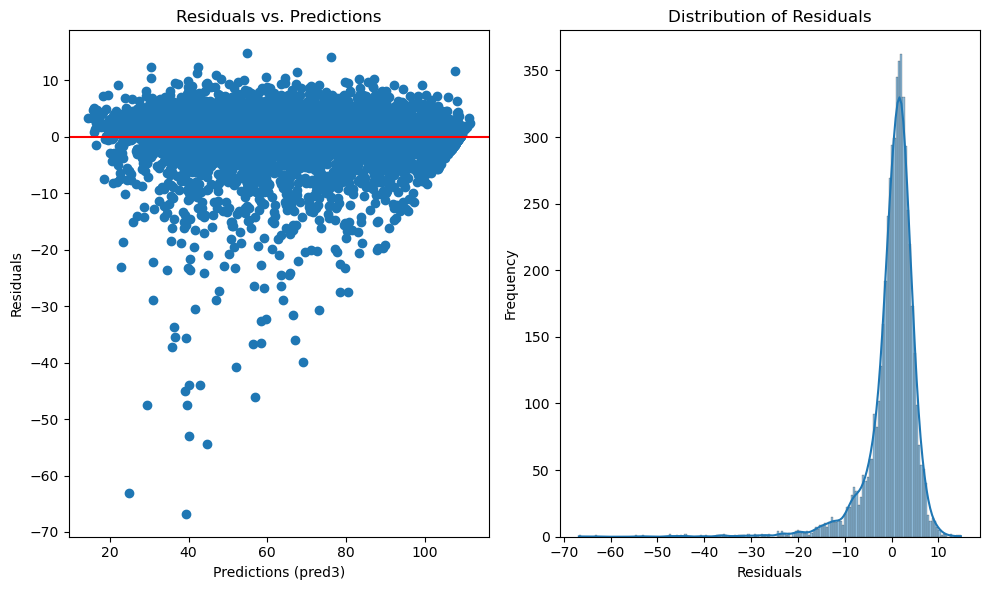

In [245]:
test3=test2[test2["TD"]==0]
X_test3=test3.drop(["uniqueid","AbsolutePostPlay","TD","predictions2"],axis=1).values
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test3["predictions"]=pred3
test3['residuals'] =  test3['predictions'] - test3['AbsolutePostPlay']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(test3['predictions'], test3['residuals'])
plt.title('Residuals vs. Predictions')
plt.xlabel('Predictions (pred3)')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.subplot(1, 2, 2)
sns.histplot(test3['residuals'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [254]:
made_tackle=data_final[(data_final["tackleMade"]==1) & (data_final["week_x"]<=4)]
nfinal_data.drop(["AbsolutePostPlay"], axis=1, inplace=True)
nfinal_data=pd.merge(nfinal_data,plays,on="uniqueid",how="left")
nfinal_data["AbsolutePostplay"]=nfinal_data["absoluteYardlineNumber"]+nfinal_data["prePenaltyPlayResult"]
nfinal_data.drop(["prePenaltyPlayResult"],axis=1,inplace=True)
combos=made_tackle[['uniqueid','frameId','tacklerNflId']].drop_duplicates()
nfinal_data=nfinal_data.merge(combos, on=["uniqueid","frameId"])

In [262]:
for index, row in nfinal_data.iterrows():
    if(row["club"]==row["possessionTeam_x"]):
        nfinal_data.loc[index,"side"]="Offense"
    else:
        nfinal_data.loc[index,"side"]="Defense"
    if(row["displayName"]=="football"):
        nfinal_data.loc[index,"side"]="Football"
nfinal_data['iscarrier'] = (nfinal_data['nflId'] == nfinal_data['ballCarrierId_x']).astype(int)
def calculate_distance(group):
    ball_carrier_x = group.loc[group['iscarrier'] == 1, 'x'].iloc[0]
    ball_carrier_y = group.loc[group['iscarrier'] == 1, 'y'].iloc[0]
    group['distance_to_carrier'] = np.sqrt((group['x'] - ball_carrier_x) ** 2 + (group['y'] - ball_carrier_y) ** 2)
    return group
nfinal_data = nfinal_data.groupby('uniqueid').apply(calculate_distance).reset_index(drop=True)
nfinal_data['side'] = pd.Categorical(nfinal_data['side'], categories=["Offense", "Defense", "Football"], ordered=True)
sorted_final2 = nfinal_data.sort_values(by=['uniqueid', 'side', 'distance_to_carrier'])

In [270]:
def update_coordinates(group):
    row_22_x = group.iloc[21]['x']
    row_22_y = group.iloc[21]['y']
    group.loc[group['nflId'] == group['tacklerNflId'], 'x'] = row_22_x+0.05
    group.loc[group['nflId'] == group['tacklerNflId'], 'y'] = row_22_y-0.05
    return group
sorted_final2 = sorted_final2.groupby("uniqueid").apply(update_coordinates)
sorted_final2=sorted_final2.reset_index(level="uniqueid",drop=True)

In [274]:
def convert_to_seconds(time_str):
    if pd.isna(time_str):  
        return None
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds
sorted_final2['gameClock_x'] = sorted_final2['gameClock_x'].apply(convert_to_seconds)
sorted_final2 = sorted_final2.groupby('uniqueid').apply(calculate_distance).reset_index(drop=True)
sorted_final3 = sorted_final2.sort_values(by=['uniqueid', 'side', 'distance_to_carrier'])

In [282]:
sorted_final3["offenseFormation_x"]=label_encoder.fit_transform(sorted_final2["offenseFormation_x"])
sorted_final3["side"]=label_encoder.fit_transform(sorted_final2["side"])
sorted_final3.drop(["displayName","nflId","club","playDirection","event","ballCarrierId_x","tackleOpportunity","possessionTeam_x","defensiveTeam_x"],axis=1,inplace=True)
sorted_final3['idx'] = sorted_final3.groupby(['uniqueid']).cumcount() + 1
sorted_final2.drop(["tacklerNflId"],axis=1,inplace=True)
sorted_final3 = sorted_final3.groupby('uniqueid').apply(calculate_distance).reset_index(drop=True)
sorted_final2['side'] = pd.Categorical(sorted_final2['side'], categories=["Offense", "Defense", "Football"], ordered=True)
sorted_final2 = sorted_final2.sort_values(by=['uniqueid', 'side', 'distance_to_carrier'])
sorted_final2.drop(["side","iscarrier"],axis=1,inplace=True)

sorted_final3.drop(["side","iscarrier"],axis=1,inplace=True)
pivot_df2 = sorted_final3.pivot(index=['uniqueid','week_x','absoluteYardlineNumber_x','AbsolutePostplay','frameId',
                                   'quarter_x','down_x','yardsToGo_x','offenseFormation_x',"expectedPoints_x","tacklerNflId",
                                   'offenseScore','defenseScore','defendersInTheBox_x',
                                   'passProbability_x','offenseWinProbability','defenseWinProbability','gameClock_x'], columns='idx')
pivot_df2.columns = [f'{col[0]}{col[1]}' for col in pivot_df2.columns]
pivot_df2.reset_index(inplace=True)


In [300]:
pivot_df2.drop(["dir23","o23"],axis=1, inplace=True)
y_true=pivot_df2["AbsolutePostplay"].values
X_predict=pivot_df2.drop(["AbsolutePostplay","defenseWinProbability","tacklerNflId","uniqueid","frameId"],axis=1).values
predTD = np.array([clf11.predict_proba(X_predict), clf21.predict_proba(X_predict), clf31.predict_proba(X_predict),
                       clf41.predict_proba(X_predict), clf51.predict_proba(X_predict),clf61.predict_proba(X_predict),
                       clf71.predict_proba(X_predict), clf81.predict_proba(X_predict)])
weighted_predictions3 = np.tensordot(predTD, weights, axes=((0),(0)))
final_probabilities3 = weighted_predictions3 / weighted_predictions3.sum(axis=1, keepdims=True)

prob3=final_probabilities3[:,1]
predictions3=np.where(prob3>=0.25,1,0)
pivot_df2["TD"]=predictions3

y_predict=stack_model.predict(X_predict)
pivot_df2["withoutTackler"]=y_predict
pivot_df2["yardssaved"]=pivot_df2["withoutTackler"]-pivot_df2["AbsolutePostplay"]

In [302]:
pivot_df3=pivot_df2[pivot_df2["TD"]==0]
predYards=pivot_df3.drop(["TD","AbsolutePostplay","uniqueid","frameId","defenseWinProbability","tacklerNflId"],axis=1).values
res=stack_model.predict(predYards)
pivot_df3["withoutTackler"]=res
TDs=pivot_df2[pivot_df2["TD"]==1]
TDs["withoutTackler"]=110
FINAL=pd.concat([TDs,pivot_df3])
FINAL["yardssaved"]=FINAL["withoutTackler"]-FINAL["AbsolutePostplay"]

In [378]:
test["AbsolutePostplay"]=test["absoluteYardlineNumber"]+test["prePenaltyPlayResult"]
final_result=pd.merge(test,FINAL[["uniqueid","withoutTackler","yardssaved"]],on="uniqueid",how="left")
final_result.loc[final_result['tackleMade'] == 0, ["yardssaved"]] = np.nan
final_result.loc[final_result['tackleMade'] == 0, ["withoutTackler"]] = np.nan
final_result["potentialSaved"]=final_result["AbsolutePostplay"]-final_result["x1"]-3
final_result.loc[final_result['tackleMade'] == 1, ["potentialSaved"]] = np.nan

In [379]:
final_result['1Dsaved'] = np.where(
    (final_result['withoutTackler'] - final_result['absoluteYardlineNumber'] > final_result['yardsToGo']) &
    (final_result['AbsolutePostplay'] - final_result['absoluteYardlineNumber'] < final_result['yardsToGo']),
    1, 
    0  
)
final_result['TDsaved'] = np.where(
    (final_result['withoutTackler'] >=110) &
    (final_result['AbsolutePostplay']<110),
    1, 
    0  
)
final_result['potential1Dsaved'] = np.where(
    (final_result['AbsolutePostplay'] -final_result["potentialSaved"]- final_result['absoluteYardlineNumber'] < final_result['yardsToGo']) &
    (final_result['AbsolutePostplay'] - final_result['absoluteYardlineNumber'] > final_result['yardsToGo']),
    1,  
    0  
)
final_result['potentialTDsaved'] = np.where(
    (final_result['AbsolutePostplay']>=110) &
    (final_result['AbsolutePostplay'] - final_result['potentialSaved'] < 110),
    1, 
    0   
)
final_result.loc[final_result['tackleMade'] == 0, ["1Dsaved","TDsaved"]] = np.nan
final_result.loc[final_result['tackleMade'] == 1, ["potential1Dsaved","potentialTDsaved"]] = np.nan
final_result["tacklerNflId"]=test_tackler
final_result = final_result.rename(columns={'tacklerNflId': 'nflId'})
final_res=pd.merge(final_result, players[["nflId","displayName"]], on="nflId",how="left")
result=final_res[["tackleMade","tackleProbability","displayName","withoutTackler","potentialSaved","yardssaved","1Dsaved","TDsaved","potential1Dsaved","potentialTDsaved"]]

In [384]:
def calculate_impact_score(row):
    if row['tackleMade'] == 1:
        if row['TDsaved'] == 1:
            score = (row['yardssaved'] * 0.2 + 7)
        else:
            score = (row['yardssaved'] * 0.2 +
                     row['1Dsaved'] * 3)
    else:
        if row['potentialTDsaved'] == 1:
            score = (-row['potentialSaved'] * 0.2 - 7)
        else:
            score = (-row['potentialSaved'] * 0.2 -
                     row['potential1Dsaved'] * 3)
    return score
result['impactScore'] = result.apply(calculate_impact_score, axis=1)

def calculate_points_added(row):
    if row['impactScore'] > 0:
        return row['impactScore'] * (1 + (1 - row['tackleProbability']))
    else:
        return row['impactScore'] * row['tackleProbability']
result['SITR'] = result.apply(calculate_points_added, axis=1)

/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_1121/2214313689.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['impactScore'] = result.apply(calculate_impact_score, axis=1)


In [391]:
grouped = result.groupby('displayName')['SITR']
average_points_added = grouped.mean()
total_points_added = grouped.sum()
combined_stats = pd.DataFrame({
    'Average SITR': average_points_added,
    'Total SITR': total_points_added
}).reset_index()
combined_stats["tackleOpportunities"]=combined_stats["Total SITR"]/combined_stats["Average SITR"]

In [433]:
combined2=combined_stats[combined_stats["tackleOpportunities"]>7]
combined3=pd.merge(combined2, players, on="displayName",how="left")
combined3.drop(["nflId","height","weight","birthDate","collegeName"],axis=1,inplace=True)
combined3.loc[combined3['position'].isin(['QB','OLB','ILB','MLB']), 'position'] = 'LB'
combined3.loc[combined3['position'].isin(['G', 'RB','CB','FS','SS','DB']), 'position'] = 'DB'
combined3.loc[combined3['position'].isin(['DT','DE','NT']),'position']='DL'

In [431]:
combined3[combined3["position"]=="DL"].sort_values(by="Average SITR",ascending=False)

,displayName,Average SITR,Total SITR,tackleOpportunities,position
129,Dre'Mont Jones,2.540556,22.865000,9.0,DL
203,John Franklin-Myers,2.234186,24.576044,11.0,DL
195,Jermaine Johnson,2.230881,17.847051,8.0,DL
76,Christian Wilkins,2.071867,35.221735,17.0,DL
161,Hassan Ridgeway,1.734139,13.873109,8.0,DL
13,Al Woods,1.670947,25.064206,15.0,DL
145,Folorunso Fatukasi,1.629233,21.180027,13.0,DL
225,Josh Sweat,1.456566,27.674757,19.0,DL
320,Osa Odighizuwa,1.434030,27.246563,19.0,DL
2,Aaron Donald,1.341627,28.174170,21.0,DL


In [434]:
combined3[combined3["position"]=="LB"].sort_values(by="Average SITR",ascending=False)

,displayName,Average SITR,Total SITR,tackleOpportunities,position
206,Jonas Griffith,3.466160,41.593916,12.0,LB
39,Bobby Okereke,3.429262,68.585240,20.0,LB
331,Quay Walker,3.327539,26.620308,8.0,LB
250,Khalil Mack,3.313411,26.507288,8.0,LB
239,Kamu Grugier-Hill,3.195736,67.110462,21.0,LB
120,Devin Bush,2.882395,34.588737,12.0,LB
382,Tremaine Edmunds,2.805190,58.908990,21.0,LB
80,Cole Holcomb,2.605566,41.689062,16.0,LB
196,Jerome Baker,2.517002,47.823041,19.0,LB
313,Nick Bolton,2.469760,39.516161,16.0,LB


In [435]:
combined3[combined3["position"]=="DB"].sort_values(by="Average SITR",ascending=False)

,displayName,Average SITR,Total SITR,tackleOpportunities,position
309,Nate Hobbs,3.889093,77.781852,20.0,DB
27,Anthony Brown,3.883124,66.013108,17.0,DB
268,Levi Wallace,3.511717,35.117167,10.0,DB
304,Myles Bryant,3.510983,31.598847,9.0,DB
238,Kaiir Elam,3.491266,34.912662,10.0,DB
325,Patrick Surtain,3.440946,37.850403,11.0,DB
56,Caleb Farley,3.244830,32.448297,10.0,DB
375,Terrance Mitchell,3.234276,29.108480,9.0,DB
283,Marshon Lattimore,3.133794,34.471731,11.0,DB
118,Derwin James,3.127214,43.780998,14.0,DB
